# Interpolation polynomial in the Lagrange form
Based on [this code](https://gist.github.com/folkertdev/084c53887c49a6248839)

$$f(x)\approx P_n(x)\,,$$

$$P_n(x) = \sum_{i=0}^n f(x_i)L_{n,i}(x) = \sum_{i=0}^n y_iL_{n,i}(x)$$

**References:**
[Wikipedia](https://en.wikipedia.org/wiki/Lagrange_polynomial)

In [1]:
%%writefile LagrangePolynomial.py
"""
From: https://gist.github.com/folkertdev/084c53887c49a6248839
A sympy-based Lagrange polynomial constructor. 
Given a set of function inputs and outputs, the lagrangePolynomial function will construct an 
expression that for every input gives the corresponding output. For intermediate values,
the polynomial interpolates (giving varying results based on the shape of your input). 
This is useful when the result needs to be used outside of Python, because the 
expression can easily be copied. To convert the expression to a python function object,
use sympy.lambdify.
"""
from sympy import symbols, expand, lambdify, solve_poly_system
from mpmath import tan, e

import math

from operator import mul
from functools import reduce, lru_cache
from itertools import chain

# sympy symbols
x = symbols('x')

# convenience functions
product = lambda *args: reduce(mul, *(list(args) + [1]))

# test data
labels = [(-3/2), (-3/4), 0, 3/4, 3/2]
points = [math.tan(v) for v in labels]

# this product may be reusable (when creating many functions on the same domain)
# therefore, cache the result
@lru_cache(16)
def l(labels, j):
    def gen(labels, j):
        k = len(labels)
        current = labels[j]
        for m in labels:
            if m == current:
                continue
            yield (x - m) / (current - m)
    return expand(product(gen(labels, j)))

def polyL(xs,j):
    '''
    Lagrange polynomials as sympy polynomial
    xs: the n+1 nodes of the intepolation polynomial in the Lagrange Form
    j: Is the j-th Lagrange polinomial for the specific xs.
    '''
    xs=tuple(xs)
    return l(xs,j)

def L(xs,j):
    '''
    Lagrange polynomials as python function
    xs: the n+1 nodes of the intepolation polynomial in the Lagrange Form
    j: Is the j-th Lagrange polinomial for the specific xs.
    '''
    return lambdify(x, polyL(xs,j) )

def lagrangePolynomial(xs, ys):
    # based on https://en.wikipedia.org/wiki/Lagrange_polynomial#Example_1
    k = len(xs)
    total = 0

    # use tuple, needs to be hashable to cache
    xs = tuple(xs)

    for j, current in enumerate(ys):
        t = current * l(xs, j)
        total += t

    return total




def x_intersections(function, *args):
    "Finds all x for which function(x) = 0"
    # solve_poly_system seems more efficient than solve for larger expressions
    return [var for var in chain.from_iterable(solve_poly_system([function], *args)) if (var.is_real)]

def x_scale(function, factor):
    "Scale function on the x-axis"
    return functions.subs(x, x / factor)

if __name__ == '__main__':
    func = lagrangePolynomial(labels, points)

    pyfunc = lambdify(x, func)

    for a, b in zip(labels, points):
        assert(pyfunc(a) - b < 1e-6)

Overwriting LagrangePolynomial.py


In [2]:
%pylab inline
import pandas as pd
import numpy as np
import LagrangePolynomial as LP
from scipy import interpolate

Populating the interactive namespace from numpy and matplotlib


## Example of interpolation of tree points with a polynomial of degree 2

In [52]:
df=pd.DataFrame({ 'X':[3,10,21.3],'Y':[8.,6.5,3.]}  )
df

,X,Y
0,3.0,8.0
1,10.0,6.5
2,21.3,3.0


### `Numpy` implementation:

           2
-0.005216 x - 0.1465 x + 8.486


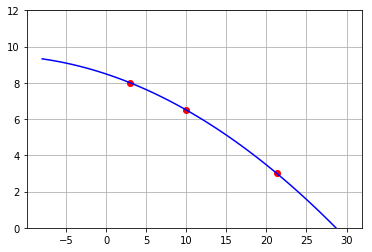

In [54]:
coeffs=np.polyfit(df.X,df.Y,deg=2)

P=np.poly1d(coeffs)
plt.plot(df.X,df.Y,'ro')
x=np.linspace(-8,30)
plt.plot(x,P( x),'b-')
plt.grid()
plt.ylim(0,12)

print(np.poly1d(coeffs))

### `Scipy` implementation of the Interpolation polynomial in the Lagrange form

In [55]:
P=interpolate.lagrange(df.X,df.Y)
print(P)

           2
-0.005216 x - 0.1465 x + 8.486


### `Sympy` implementation of the Interpolation polynomial in the Lagrange form

In [7]:
LP.lagrangePolynomial(df.X,df.Y)

-0.00521578136549849*x**2 - 0.146480556534234*x + 8.48638370189219

Check:
$$P_2(x) =  L_{2,0}(x)f(x_0)+L_{2,2}(x)f(x_1)+L_{2,2}(x)f(x_2)$$

As `sympy` polynomial

In [12]:
LP.polyL( df.X,0)*df.Y[0]+LP.polyL( df.X,1)*df.Y[1]+LP.polyL( df.X,2)*df.Y[2]

-0.00521578136549849*x**2 - 0.146480556534234*x + 8.48638370189219

As a function

In [58]:
def P_2(x,xs,ys):
    return LP.L(xs,0)(x)*ys[0]+LP.L(xs,1)(x)*ys[1]+LP.L( xs,2)(x)*ys[2]

(0, 12)

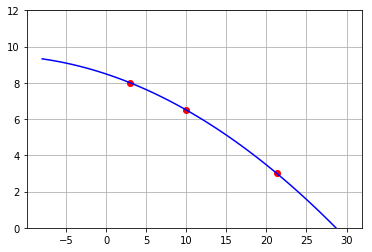

In [61]:
plt.plot(df.X,df.Y,'ro')
x=np.linspace(-8,30)
plt.plot(x,P_2( x,df.X,df.Y),'b-')
plt.grid()
plt.ylim(0,12)

## Lagrange polynomial properties
$$L_{n,i}(x_i) = 1\,,\qquad\text{and}\,,\qquad L_{n,i}(x_j) = 0\quad\text{for $i\neq j$}$$ 

As `sympy` objects

In [32]:
L2_0=LP.polyL(df.X,0)

In [49]:
L2_0.as_poly()(df.X[0])

1.00000000000000

In [51]:
L2_0.as_poly()(df.X[2])

-6.66133814775094e-16

As `python` function

In [50]:
print( LP.L(df.X,0)(df.X[0]),LP.L(df.X,1)(df.X[1]),LP.L(df.X,2)(df.X[2]) )

1.0 1.0 1.0


In [62]:
LP.L(df.X,0)(df.X)

0    1.000000e+00
1   -4.440892e-16
2    5.329071e-15
Name: X, dtype: float64

In [63]:
LP.L(df.X,1)(df.X)

0   -1.429412e-15
1    1.000000e+00
2   -2.131628e-14
Name: X, dtype: float64

In [64]:
LP.L(df.X,2)(df.X)

0    1.665335e-16
1    0.000000e+00
2    1.000000e+00
Name: X, dtype: float64